In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import LinearSVC

from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import optLib as opt

from matplotlib import pyplot as plt
import time as t
import random

In [3]:
def mySVM( X ):
    return X.dot(w) + b

# Stochastic Dual Coordinate Maximization
def doCoordOptCSVMDual( alpha, i, t ):
    global w_SDCM, b_SDCM, normSq
    x = X[i,:]
    
    # Find the unconstrained new optimal value of alpha_i
    # It takes only O(d) time to do so because of our clever book keeping
    newAlphai =  alpha[i] + (1 - y[i] * (x.dot(w_SDCM) + b_SDCM)) / normSq[i]
    
    # Make sure that the constraints are satisfied. This takes only O(1) time
    if newAlphai > C:
        newAlphai = C
    if newAlphai < 0:
        newAlphai = 0

    # Update the primal model vector and bias values to ensure bookkeeping is proper
    # Doing these bookkeeping updates also takes only O(d) time
    w_SDCM = w_SDCM + (newAlphai - alpha[i]) * y[i] * x
    b_SDCM = b_SDCM + (newAlphai - alpha[i]) * y[i]
    
    return newAlphai

# Get the primal and the dual CSVM objective values in order to plot convergence curves
# This is required for the dual solver which optimizes the dual objective function
def getCSVMPrimalDualObjVals( alpha ):
    global w_SDCM, b_SDCM
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w_SDCM ) + b_SDCM), y ), 0 )
    objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + C * np.sum(hingeLoss)
    # Recall that b is supposed to be treated as the last coordinate of w
    objDual = np.sum( alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) ) - 0.5 * b_SDCM * b_SDCM
    
    return np.array( [objPrimal, objDual] )

In [4]:
data = np.loadtxt( "APUF_CRP.txt" )

def createFeatures( X ):
    return np.cumprod( np.flip( 2 * X - 1 , axis = 1 ), axis = 1 )

data_trn, data_tst = train_test_split( data, train_size = 10000 )

X_raw = data_trn[:,:-1]
X = createFeatures( X_raw )
y = data_trn[:,-1]

y = np.where( y > 0, 1, -1 )

X_t_raw = data_tst[:,:-1]
X_t = createFeatures( X_t_raw )
y_t = data_tst[:,-1]

y_t = np.where( y_t > 0, 1, -1 )

In [10]:
C = 1

coordFunc = opt.coordinateGenerator( "randperm", y.size )

initDual = C * np.ones( ( y.size, ) )

normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1

alphayInit = np.multiply( initDual, y )
w_SDCM = X.T.dot( alphayInit )

b_SDCM = initDual.dot( y )

(alpha_SDCM, obj_SDCM, time_SDCM) = opt.doSDCM( doCoordOptCSVMDual, coordFunc, getCSVMPrimalDualObjVals, initDual, horizon = 5000 )

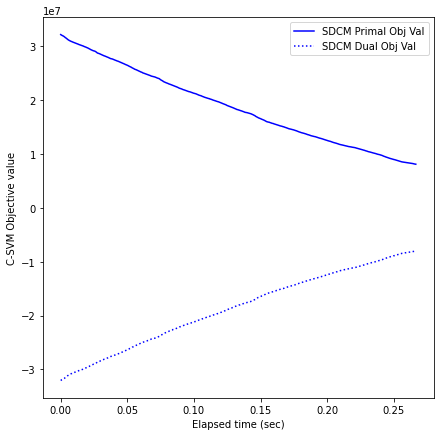

In [11]:
fig1 = pd.getFigure( 7, 7 )
plt.figure( fig1.number )
primal_SDCM = [obj_SDCM[i][0] for i in range(len(obj_SDCM))]
dual_SDCM = [obj_SDCM[i][1] for i in range(len(obj_SDCM))]
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )

# plt.ylim( np.median( dual_SDCM ), np.median( primal_SDCM ) )

plt.show()

In [12]:
def eval( theta, name ):
    global X_t, y_t
    global w, b
    w = theta[0:-1]
    b = theta[-1]
    y_t_pred = mySVM( X_t )
    y_t_pred = np.where( y_t_pred > 0, 1, -1 )
    print( name, np.average( y_t == y_t_pred ) )

eval( np.append( w_SDCM, b_SDCM ), "SDCM" )

SDCM 0.9753333333333334


**Implementing Gradient Descent Variants**: below we implement four variants of the basic gradient descent algorithm. For step lengths, we are using the scheme $\eta_t = \frac\eta t$ which is recommended for functions such as the CSVM objective that satisfy a property known as "strong convexity" but are nevertheless, not differentiable. GD variants perform very well on strongly convex functions like the CSVM objective.

Note that the gradient oracles have the option of using iteration information as well. We will use this flexibility when implementing variable batch-sized SGD

1. Vanilla Gradient Descent: the word "vanilla" is often used to refer to something that is plain or simple
1. Stochastic Gradient Descent: simply choose a random data point per iteration
1. Mini-batch Stochastic Gradient Descent: choose a random (without replacement) set of $B$ samples per iteration. The batch size $B$ is a hyperparameter for this method
1. Variable Batch-size Stochastic Gradient Descent: a variant of the mini-batch stochastic gradient where batch sizes go up gradually as the optimization progresses. This makes sense -- when we begin the optimization process, we only need a rough idea of the direction in which to proceed. However, as we make more and more progress, we would ideally need less noisy directions which can be achieved by using larger batch sizes. How frequently to update the batch size and how much to increase it at each update are two hyperparameters of this method.

In [13]:
# Vanilla Gradient Descent
def getCSVMGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = np.multiply( (X.dot( w ) + b), y )
    g = np.zeros( (y.size,) )
    g[discriminant < 1] = -1
    delb = C * g.dot( y )
    delw = w + C * (X.T * g).dot( y )
    return np.append( delw, delb )

# Stochastic Gradient Descent
def getCSVMSGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    i = random.randint( 0, n-1 )
    x = X[i,:]
    discriminant = (x.dot( w ) + b) * y[i]
    g = 0
    if discriminant < 1:
        g = -1
    delb = C * n * g * y[i]
    delw = w + C * n * (x * g) * y[i]
    return np.append( delw, delb )

# Mini-batch Stochastic Gradient Descent
def getCSVMMBGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    # Be careful not to ask for more samples than there are training points
    # otherwise the sample() routine will throw an exception
    B_eff = min( B, n )
    samples = random.sample( range(0, n), B_eff )
    X_ = X[samples,:]
    y_ = y[samples]
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B_eff,) )
    g[discriminant < 1] = -1
    delb = C * n/B_eff * g.dot( y_ )
    delw = w + C * n/B_eff * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Variable Batch-size Stochastic Gradient Descent
def getCSVMVarMBGrad( theta, t ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    # Increase the batch size every few iterations -- there are two tuneable hyperparameters here
    # How frequently to update the batch size and how much to increase it at each update
    B_eff = min( B * int( pow(1.2, t//40) ), n )
    samples = random.sample( range(0, n), B_eff )
    X_ = X[samples,:]
    y_ = y[samples]
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B_eff,) )
    g[discriminant < 1] = -1
    delb = C * n/B_eff * g.dot( y_ )
    delw = w + C * n/B_eff * (X_.T * g).dot( y_ )
    return np.append( delw, delb )

# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    return 0.5 * w.dot( w ) + C * np.sum( hingeLoss )

**Case Study with the CSVM Objective**: Let us now try out our various GD solvers on the CSVM objective. CSVM problems get progressively more and more difficult as $C$ goes up. All solvers, GD/SGD/sklearn will struggle with large values of $C$. Change the values of $\eta, C$ below and experiment to observe that SGD and mini-batch SGD offer much faster convergence than GD, especially when the number of data points i.e. $n$ is large.

**Model Averaging**: GD variants, especially when executed on non-differentiable functions, often find it a bit difficult to converge very close to the global optimum, even if the function is convex. A nice way to ensure good convergence even for non-differentiable functions is to average successive iterates of the GD process and use the average model as the final output. This averaging technique can be shown to provably converge to the global optimum (proof beyond scope of CS771).

In [14]:
def mySVM( X ):
    return X.dot(w) + b

C = 1
eta = 1
B = 10
d = X.shape[1]

init = np.zeros( (d+1,) )
stepFunc = opt.stepLengthGenerator( "linear", eta )

(thetaGD, objGD, timeGD) = opt.doGD( getCSVMGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaSGD, objSGD, timeSGD) = opt.doGD( getCSVMSGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaMB, objMB, timeMB) = opt.doGD( getCSVMMBGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )
(thetaVarMB, objVarMB, timeVarMB) = opt.doGD( getCSVMVarMBGrad, stepFunc, getCSVMObjVal, init, horizon = 500, doModelAveraging = True )

GD 0.9953111111111111
SGD 0.8358111111111111
MB 0.9471444444444445
VarMB 0.9447
SDCM 0.9753333333333334


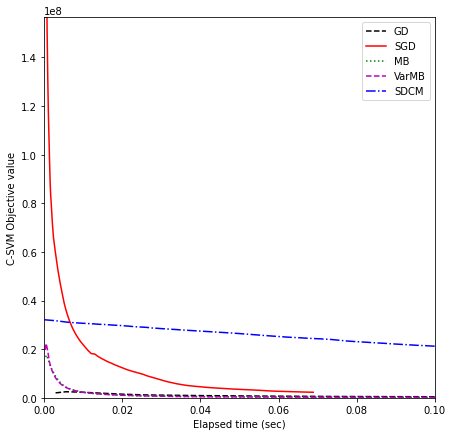

In [17]:
eval( thetaGD, "GD" )
eval( thetaSGD, "SGD" )
eval( thetaMB, "MB" )
eval( thetaVarMB, "VarMB" )
eval( np.append( w_SDCM, b_SDCM ), "SDCM" )

fig2 = pd.getFigure( 7, 7 )
plt.figure( fig2.number )
plt.plot( timeGD, objGD, color = 'k', linestyle = '--', label = "GD" )
plt.plot( timeSGD, objSGD, color = 'r', linestyle = '-', label = "SGD" )
plt.plot( timeMB, objMB, color = 'g', linestyle = ':', label = "MB" )
plt.plot( timeVarMB, objVarMB, color = 'm', linestyle = '--', label = "VarMB" )
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-.', label = "SDCM" )

plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.legend()
# Plot the results of the last blah iterates of all methods
blah = 500
plt.ylim( 0, max(primal_SDCM[-blah], objSGD[-blah], objMB[-blah], objGD[-blah], objVarMB[-blah]) )
plt.xlim( 0, 0.1 )
plt.show()